## Курсовой проект по предмету "Python для Data Science"
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
data = pd.read_csv('train.csv')
data.shape

(10000, 20)

##### Разделение данных на train и valid.

In [3]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

### 1. Подготовка данных train 
##### Коррекция данных в столбце Healthcare_1 
Удаление столбца Healthcare_1, заполненного на 52%.

In [4]:
def drop_empty_column(data):
    data = data.drop('Healthcare_1', axis=1)
    return data

In [5]:
train = drop_empty_column(train)

##### Коррекция данных в столбце HouseYear
Коррекция данных по году постройки зданий - ранее 1900 года и позднее 2020 года.

In [6]:
def correct_year(data):
    data.loc[data['HouseYear']<1900, 'HouseYear'] = 1900
    data.loc[data['HouseYear']>2020, 'HouseYear'] = 2020
    return data

In [7]:
train = correct_year(train)

##### Коррекция данных в столбце Rooms
Коррекция количества комнат для квартир с большим количеством комнат (больше 5) и с количеством 0 комнат. 

In [8]:
train.loc[train['Rooms'] > 5, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,3,8,B,229661.964416
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.323792


In [9]:
train.loc[train['Id'].isin([5927, 14003]), 'Rooms'] = 2 
train.loc[train['Id'] == 8491, 'Rooms'] = 1 

In [10]:
train.loc[train['Rooms'] == 0, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,0,0,B,212864.799112
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,0,0,B,268394.744389
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.338463
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.941798


In [11]:
train.loc[train['Id'].isin([12638]), 'Rooms'] = 6
train.loc[train['Id'].isin([7317, 770, 3224]), 'Rooms'] = 1
train.loc[train['Id'].isin([456]), 'Rooms'] = 3

##### Коррекция данных в столбце Square

mean_square = площадь, усреднённая по квартирам с таким же количеством комнат.

При Square менее 15 заменяем её на mean_square. 

При Square более 150 при явном несоответствии площади признакам Rooms и Price (неправдоподобно малое количество комнат и/или малая цена) вручную производим замену на mean_square.

In [12]:
mean_square = train.groupby('Rooms', as_index=False)[['Square']].mean().rename(columns={'Square':'mean_square'})
mean_square

,Rooms,mean_square
0,1.0,41.354876
1,2.0,56.810018
2,3.0,77.131619
3,4.0,98.651884
4,5.0,103.645574
5,6.0,138.427694


In [13]:
train = pd.merge(train, mean_square, on='Rooms', how='left')
small_square = train.loc[train['Square'] < 15, 'Id'].values
train.loc[train['Id'].isin(small_square), 'Square'] = train['mean_square']

Просмотр квартир с площадью Square > 150 и дальнейшее исправление явных ошибок в ручном режиме

In [14]:
train.loc[train['Square'] > 150, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,mean_square
1,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,0,0,B,207007.956663,77.131619
202,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,1,4,B,528560.506016,98.651884
492,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,2,4,B,187717.242538,56.810018
854,16204,23,1.0,160.647588,NaN,1.0,3,3.0,1977,0.014073,B,B,2,475,0,0,0,B,217874.997452,41.354876
1358,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,2,6,B,338644.075979,77.131619
1569,3914,24,4.0,155.930023,76.831293,15.0,6,22.0,2012,0.111627,B,B,50,12238,8,2,3,B,559886.965348,98.651884
1883,14556,183,4.0,151.150660,98.187482,23.0,6,7.0,1912,0.037316,B,B,32,6748,93,4,10,B,284884.959104,98.651884
2301,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,5,15,B,622888.825328,103.645574
2571,2603,30,3.0,162.587886,164.526757,0.0,2,3.0,1977,0.000078,B,B,22,6398,141,3,23,B,207407.352593,77.131619
2780,14181,62,3.0,156.636577,153.685835,1.0,1,3.0,2005,0.072158,B,B,2,629,1,0,0,A,502523.573863,77.131619


In [15]:
train.loc[train['Id'].isin([28, 2307, 5376]), 'Square'] = train['mean_square']

###### Функции correct_square(data) и correct_rooms(data) сделаны для подготовки данных valid и test

In [16]:
def correct_rooms(data):
    data = pd.merge(data, mean_square, on='Rooms', how='left')
    
    big_rooms = data.loc[data['Rooms'] > 5, 'Id'].values
    small_rooms = data.loc[(data['Rooms'] == 0)|(data['Rooms'].isin(['NaN'])), 'Id'].values
    
    for id_flat in big_rooms:
        for i in range(1, 5):
            if mean_square.loc[mean_square['Rooms'] == i, 'mean_square'].values[0] <= data.loc[data['Id'] == id_flat, 'Square'].values[0] <= mean_square.loc[mean_square['Rooms'] == i + 1, 'mean_square'].values[0]:
                data.loc[data['Id'] == id_flat, 'Square'] = data['mean_square']
    for id_flat in small_rooms:
        for i in range(1, 5):
            if mean_square.loc[mean_square['Rooms'] == i, 'mean_square'].values[0] <= data.loc[data['Id'] == id_flat, 'Square'].values[0] <= mean_square.loc[mean_square['Rooms'] == i + 1, 'mean_square'].values[0]:
                data.loc[data['Id'] == id_flat, 'Square'] = data['mean_square']
    return data

In [17]:
def correct_square(data):
        
    data.loc[(data['Square'] > 150)&(data['Rooms'] < 5), 'Square'] = data['mean_square']
    data.loc[data['Square'] < 15, 'Square'] = data['mean_square']
    data.loc[data['Square'].isin(['NaN']), 'Square'] = data['LifeSquare']
    
    return data

##### Коррекция данных в столбце LifeSquare

Если LifeSquare больше Square, то LifeSquare заменяется на Square.

mean_LifeSquare_ratio = среднее отношение LifeSquare к Square. 

Если LifeSquare меньше Square, делённой на 4, или меньше 10, то значение LifeSquare заменяется на  Square/mean_LifeSquare_ratio.

Если LifeSquare == 'NaN', то значение LifeSquare принимается равным Square/mean_LifeSquare_ratio.

In [18]:
def correct_life_square(data):
    big_LifeSquare = data.loc[data['Square'] < data['LifeSquare'], 'Id'].values
    data.loc[data['Id'].isin(big_LifeSquare), 'LifeSquare'] = data['Square']

    small_LifeSquare = data.loc[(data['Square'] > 4 * data['LifeSquare'])|(data['LifeSquare'] < 10), 'Id'].values
    mean_LifeSquare_ratio = data.loc[~data['Id'].isin(small_LifeSquare), 'Square'].sum() / data.loc[~data['Id'].isin(small_LifeSquare), 'LifeSquare'].sum()
    
    data.loc[data['Id'].isin(small_LifeSquare), 'LifeSquare'] = data['Square'] / mean_LifeSquare_ratio
    
    nan_LifeSquare = data.loc[data['LifeSquare'].isin(['NaN']), 'Id'].values
    data.loc[data['Id'].isin(nan_LifeSquare), 'LifeSquare'] = data['Square'] / mean_LifeSquare_ratio
    return data

In [19]:
train = correct_life_square(train)

##### Коррекция данных в столбце KitchenSquare

In [20]:
mean_KitchenSquare = train.groupby('Rooms', as_index=False)[['KitchenSquare']].mean().rename(columns={'KitchenSquare':'mean_KitchenSquare'})
mean_data_square = pd.merge(mean_square, mean_KitchenSquare, on='Rooms', how='inner')
mean_data_square['KitchenSquare_ratio'] = mean_data_square['mean_square'] / mean_data_square['mean_KitchenSquare']
mean_data_square

,Rooms,mean_square,mean_KitchenSquare,KitchenSquare_ratio
0,1.0,41.354876,7.026944,5.885187
1,2.0,56.810018,5.623396,10.102440
2,3.0,77.131619,6.950609,11.097102
3,4.0,98.651884,8.796117,11.215391
4,5.0,103.645574,8.500000,12.193597
5,6.0,138.427694,0.000000,inf


In [21]:
mean_data_square.loc[mean_data_square['mean_KitchenSquare'] == 0, 'mean_KitchenSquare'] = 15
mean_data_square.loc[mean_data_square['KitchenSquare_ratio'].isin(['inf']), 'KitchenSquare_ratio'] = mean_data_square['mean_square'] / mean_data_square['mean_KitchenSquare']
mean_KitchenSquare_ratio = mean_data_square.drop(['mean_square', 'mean_KitchenSquare'], axis=1)
mean_KitchenSquare_ratio

,Rooms,KitchenSquare_ratio
0,1.0,5.885187
1,2.0,10.102440
2,3.0,11.097102
3,4.0,11.215391
4,5.0,12.193597
5,6.0,9.228513


Если ПлощадьКухни == 0, то значение ПлощадьКухни заменяется на 15 кв.м для квартир с 4, 5 и 6 комнатами.

Для квартир с 1, 2 и 3 комнатами если ПлощадьКухни == 0, то значение ПлощадьКухни заменяется на значение  Площадь/KitchenSquare_ratio (среднее отношение Площади к ПлощадиКухни - KitchenSquare_ratio).

In [22]:
def correct_kitchen_square(data):
    
    data = pd.merge(data, mean_KitchenSquare_ratio, on='Rooms', how='left')
    
    nan_KitchenSquare = data.loc[data['KitchenSquare'] == 0, 'Id'].values
    small_KitchenSquare = data.loc[data['KitchenSquare'] < 4, 'Id'].values
    big_KitchenSquare = data.loc[data['KitchenSquare'] > 15, 'Id'].values
    
    data.loc[data['Id'].isin(small_KitchenSquare), 'KitchenSquare'] = 4
    data.loc[data['Id'].isin(big_KitchenSquare), 'KitchenSquare'] = data['Square'] / data['KitchenSquare_ratio']
    
    if data.loc[data['Id'].isin(nan_KitchenSquare), 'Rooms'].values is any([4, 5, 6]):
        data.loc[data['Id'].isin(nan_KitchenSquare), 'KitchenSquare'] = 15
    elif data.loc[data['Id'].isin(nan_KitchenSquare), 'Rooms'].values is any([1, 2, 3]):
        data.loc[data['Id'].isin(nan_KitchenSquare), 'KitchenSquare'] = data['Square'] / data['KitchenSquare_ratio']
    
    return data

In [23]:
train = correct_kitchen_square(train)

##### Коррекция данных в столбце HouseFloor
При HouseFloor менее значения Floor, значение HouseFloor заменяется на значение Floor.

In [24]:
def correct_house_floor(data):
    data.loc[data['HouseFloor'] < data['Floor'], 'HouseFloor'] = data['Floor']
    return data

In [25]:
train = correct_house_floor(train)

##### Коррекция столбцов Ecology_2, Ecology_3 и Shops_2
В столбцах с переменными Object производится замена А и В на 0 и 1.

In [26]:
def correct_object_columns(data, columns_names):
    for item in columns_names:
        data.loc[data[item] == 'A', item] = 0
        data.loc[data[item] == 'B', item] = 1
        
    return data

In [27]:
columns_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
train = correct_object_columns(train, columns_names)

##### Добавление столбцов с усреднёнными данными
Столбцы (1) с усреднением количества квартир по районам, (2) с усреднением цены по районам и количеству комнат, (3) с усреднением цены по площади квартиры (значения площади разбиты на 10 участков). 

In [28]:
flats_per_distr = train['DistrictId'].value_counts(normalize=True).reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'fl_per_distr'})

def add_column_1(data, flats_per_distr):
    data = pd.merge(data, flats_per_distr, on='DistrictId', how='left')
    data['fl_per_distr'] = data['fl_per_distr'].fillna(0.000143)
    return data

In [29]:
price_per_distr = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price']].mean().rename(columns={'Price':'price_per_distr'})
mean_price = train['Price'].mean()

def add_column_2(data, price_per_distr, mean_price):
    data = pd.merge(data, price_per_distr, on=['DistrictId', 'Rooms'], how='left')
    data['price_per_distr'] = data['price_per_distr'].fillna(mean_price)
    return data

In [30]:
ma = train['Square'].max()
mi = train['Square'].min()
item_sq = (ma - mi)/9
sq_array = []
item = mi

for _ in range(10):
    sq_array.append(item)
    item = item + item_sq

In [31]:
def price_per_square(data, sq_array):
    
    sq_loc_first = data.loc[data['Square'] <= sq_array[1], 'Id'].values
    sq_loc_last = data.loc[data['Square'] > sq_array[8], 'Id'].values
           
    for i in sq_loc_first:
        data.loc[data['Id'] == i, 'price_per_square'] = data.loc[data['Id'].isin(sq_loc_first), 'Price'].mean()
        
    for i in sq_loc_last:
        data.loc[data['Id'] == i, 'price_per_square'] = data.loc[data['Id'].isin(sq_loc_last), 'Price'].mean()
    
    for i in range(1, 8):
        for id_sq in (data.loc[(data['Square'] > sq_array[i]) & (data['Square'] <= sq_array[i+1]), 'Id'].values):
            data.loc[data['Id'] == id_sq, 'price_per_square'] = data.loc[(data['Square'] > sq_array[i]) & (data['Square'] <= sq_array[i+1]), 'Price'].mean()
    return data

train = price_per_square(train, sq_array)

In [32]:
sq_arr = pd.DataFrame(sq_array, columns=['sq_limits'])
sq_arr = sq_arr.drop(0, axis=0).reset_index(drop=True)
add_info = pd.DataFrame(train['price_per_square'].value_counts(normalize=True)).reset_index().rename(columns={'index':'price_per_square', 'price_per_square': 'percent'})
add_info = add_info.sort_values(by='price_per_square').reset_index(drop=True)
mean_sq_price = pd.concat([add_info, sq_arr], axis=1).drop('percent', axis=1)
mean_sq_price

,price_per_square,sq_limits
0,148353.157896,36.585753
1,181162.902835,57.054351
2,233526.420087,77.522949
3,243438.416492,97.991548
4,300996.100195,118.460146
5,343309.210580,138.928744
6,368670.876481,159.397343
7,386812.267008,179.865941
8,457591.661394,200.334539


In [33]:
def price_per_square_test(data, mean_sq_price):

    for i in range(9):
        for id_sq in data.loc[data['Square'] <= mean_sq_price['sq_limits'][i], 'Id'].values:
            data.loc[data['Id'] == id_sq, 'price_per_square'] = mean_sq_price['price_per_square'][i]
        for id_sq in data.loc[data['Square'] > mean_sq_price['sq_limits'][8], 'Id'].values:
            data.loc[data['Id'] == id_sq, 'price_per_square'] = mean_sq_price['price_per_square'][8]
            
    return data

In [34]:
train = add_column_1(train, flats_per_distr)
train = add_column_2(train, price_per_distr, mean_price)

##### Удаление вспомогательных столбцов, добавленных при подготовке данных
В конце подготовки убираются вспомогательные столбцы.

In [35]:
def drop_added_columns(data):
    data = data.drop(['mean_square', 'KitchenSquare_ratio'], axis=1)
    return data

In [36]:
train = drop_added_columns(train)

### 2. Подготовка данных valid

In [37]:
def data_prepare(df, columns_names, flats_per_distr, price_per_distr, mean_price, mean_sq_price):
    df = drop_empty_column(df)
    df = correct_year(df)
    df = correct_rooms(df)
    df = correct_square(df)
    df = correct_life_square(df)
    df = correct_kitchen_square(df)
    df = correct_house_floor(df)
    df = correct_object_columns(df, columns_names)
    df = add_column_1(df, flats_per_distr)
    df = add_column_2(df, price_per_distr, mean_price)
    df = price_per_square_test(df, mean_sq_price)
    df = drop_added_columns(df)
    return df

In [38]:
valid = data_prepare(valid, columns_names, flats_per_distr, price_per_distr, mean_price, mean_sq_price)

###### Разделение данных 

In [39]:
feature_names = train.columns
feature_names = feature_names.drop('Price')

In [40]:
def prepare_set(data, mode):
    if mode == 'X':
        ready_set = pd.DataFrame(data, columns = feature_names)
    elif mode == 'y':
        ready_set = pd.DataFrame(data, columns = ['Price'])
    return ready_set

In [41]:
X_train = prepare_set(train, 'X')
y_train = prepare_set(train, 'y')
X_valid = prepare_set(valid, 'X')
y_valid = prepare_set(valid, 'y')

### 3. Модель Метода Случайный лес (Random Forest)

In [130]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

###### Построение модели

In [131]:
parameters = { 
    'n_estimators': [100, 150, 200],
    'max_depth': [12, 13, 14]
}
grid_s = GridSearchCV(estimator = RF(random_state=42), param_grid=parameters, cv = 5)
grid_s.fit(X_train, y_train['Price'])
grid_s.best_params_ 

{'max_depth': 13, 'n_estimators': 150}

In [188]:
model = RF(n_estimators=grid_s.best_params_['n_estimators'], 
           max_depth=grid_s.best_params_['max_depth'], 
           min_samples_leaf=2, 
           random_state=42)

In [189]:
feats = ['Square', 'Rooms', 'Social_1', 'Social_2', 'KitchenSquare', 'Floor', 
         'HouseFloor', 'Helthcare_2', 'price_per_square', 'HouseYear', 'Ecology_1', 'Ecology_2', 
         'Ecology_3', 'Social_3', 'Shops_1', 'Shops_2']

In [190]:
model.fit(X_train.loc[:, feats], y_train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [191]:
y_pred_valid = pd.DataFrame(model.predict(X_valid.loc[:, feats]), columns = ['Price'])
y_pred_train = pd.DataFrame(model.predict(X_train.loc[:, feats]), columns = ['Price'])

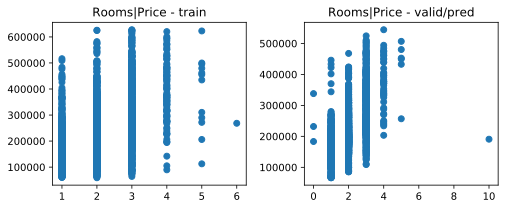

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()
ax1.scatter(X_train['Rooms'], y_train['Price'])
ax1.set_title('Rooms|Price - train')
ax2.scatter(X_valid['Rooms'], y_pred_valid['Price'])
ax2.set_title('Rooms|Price - valid/pred')
fig.set_size_inches(8, 3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

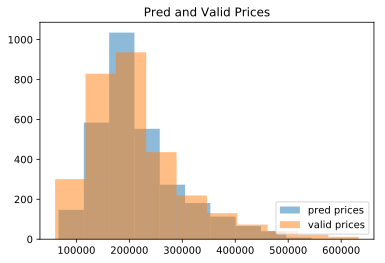

In [193]:
plt.hist(y_pred_valid['Price'], alpha=0.5, label='pred prices');
plt.hist(y_valid['Price'], alpha=0.5, label='valid prices')
plt.title('Pred and Valid Prices');
plt.legend(loc='lower right');

### 4. Оценка точности предсказаний

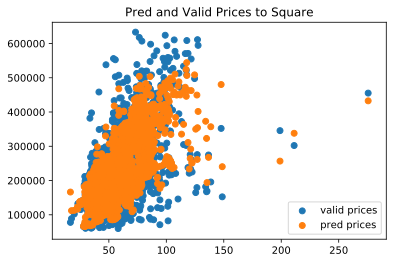

In [194]:
plt.scatter(X_valid['Square'], y_valid['Price'], label='valid prices');
plt.scatter(X_valid['Square'], y_pred_valid['Price'], label='pred prices');
plt.legend(loc='lower right');
plt.title('Pred and Valid Prices to Square');

###### Среднеквадратичная ошибка

In [195]:
mse = mean_squared_error(y_valid['Price'], y_pred_valid['Price'])
mse

2467398658.387431

###### R**2 на train

In [196]:
r2_score(y_train['Price'], y_pred_train['Price'])

0.8968620647755019

###### R**2 на valid

In [197]:
r2_score(y_valid['Price'], y_pred_valid['Price'])

0.7131517163351627

### 5. TEST

In [198]:
test = pd.read_csv('test.csv')

In [199]:
test = data_prepare(test, columns_names, flats_per_distr, price_per_distr, mean_price, mean_sq_price)

In [200]:
test['Price'] = model.predict(test.loc[:, feats])

In [201]:
test.loc[:, ['Id', 'Price']].to_csv('DAntonov_predictions.csv', index=None)